# Rudimentary Training Dataset Creation

In [43]:
import pandas as pd
import json 
import langid
import seaborn as sns

data_path = "projects/text_adventure/data/"
files = ["arceus_reviews.csv", "animal_crossing_user_reviews.csv"]

**Goal:** Come up with a Score/10 -> Sentiment Score mapping

As a proxy-sentiment score I take review datasets and treat 'rating' as a measure of sentiment.

## Legends Arceus Reviews

In [44]:
arc_df = pd.read_csv(files[0])
arc_df.head()

,review,date,score,helpful,number_of_reviews,number_of_ratings,average_user_score
0,"A fun reinvention of the Pokémon formula, hope...","Jan 29, 2022",10,49 of 62 users found this helpful,2 Reviews,2 Ratings,0.0
1,"A fun, challenging (at times), Pokemon game wi...","Jan 30, 2022",10,52 of 72 users found this helpful,60 Reviews,111 Ratings,5.8
2,El juego más infravalorado de la saga y posibl...,"Jan 29, 2022",10,48 of 62 users found this helpful,8 Reviews,12 Ratings,7.2
3,"Best pokemon game of all time! New pokemon, ne...","Jan 30, 2022",10,28 of 35 users found this helpful,1 Review,4 Ratings,5.0
4,"One outstanding experience, that is certain. I...","Feb 3, 2022",10,4 of 8 users found this helpful,1 Review,14 Ratings,9.0


In [45]:
# drop to only necessary cols
arc_df = arc_df[["review", "score", "number_of_reviews", "number_of_ratings", "average_user_score"]]

In [46]:
# convert review counts to integers
def rev_count_to_int(a):
    return int(a.lower().replace("reviews", "").replace("review", ""))

def rat_count_to_int(a):
    return int(a.lower().replace("ratings", "").replace("rating", ""))

arc_df["number_of_reviews"] = arc_df["number_of_reviews"].apply(rev_count_to_int)
arc_df["number_of_ratings"] = arc_df["number_of_ratings"].apply(rat_count_to_int)

In [47]:
# drop any nans
arc_df.dropna(inplace=True)
arc_df.shape

(1067, 5)

In [48]:
# filter to only english
def is_en(a):
    return langid.classify(a)[0]

arc_df = arc_df[arc_df["review"].apply(is_en) == "en"]
arc_df.shape

(833, 5)

In [49]:
# looking for relationship between average user score and score
# possible use of weighting the user's score by their average score
arc_df.describe()

,score,number_of_reviews,number_of_ratings,average_user_score
count,833.000000,833.000000,833.000000,833.000000
mean,7.462185,8.632653,12.727491,2.364226
std,3.225324,65.368497,70.511755,3.573869
min,0.000000,1.000000,1.000000,0.000000
25%,6.000000,1.000000,1.000000,0.000000
50%,9.000000,1.000000,2.000000,0.000000
75%,10.000000,4.000000,6.000000,6.100000
max,10.000000,1779.000000,1779.000000,10.000000


In [50]:
# remove outliers by cropping n_reviews to within 2 stds of the mean
mu = arc_df["number_of_reviews"].describe()["mean"]
std = arc_df["number_of_reviews"].describe()["std"]

arc_df = arc_df[arc_df["number_of_reviews"] < (mu + (2*std))]
arc_df.shape

(827, 5)

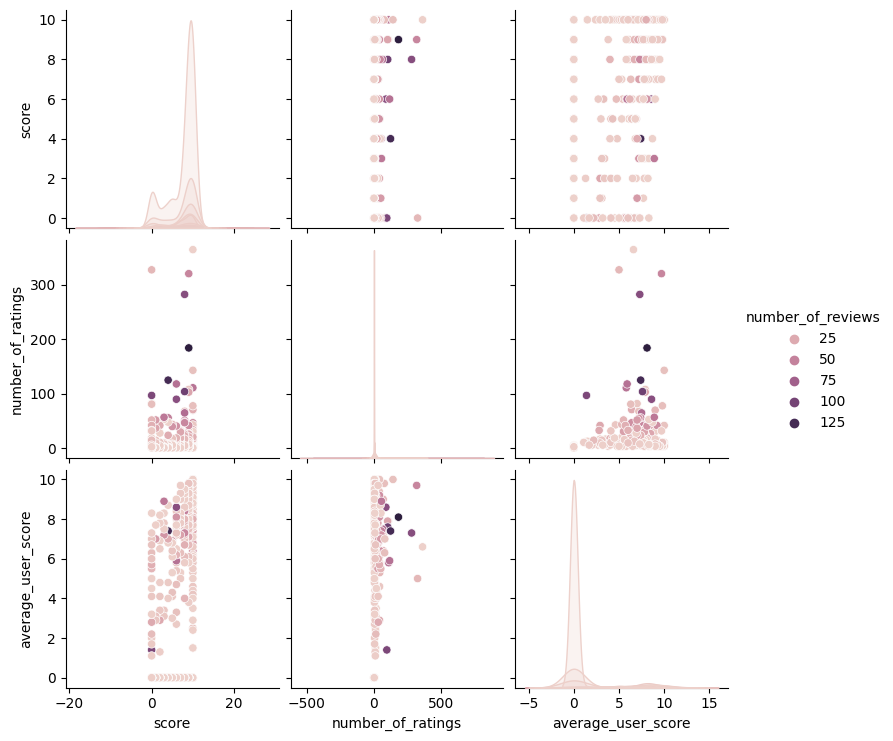

In [51]:
sns.pairplot(arc_df, hue="number_of_reviews")

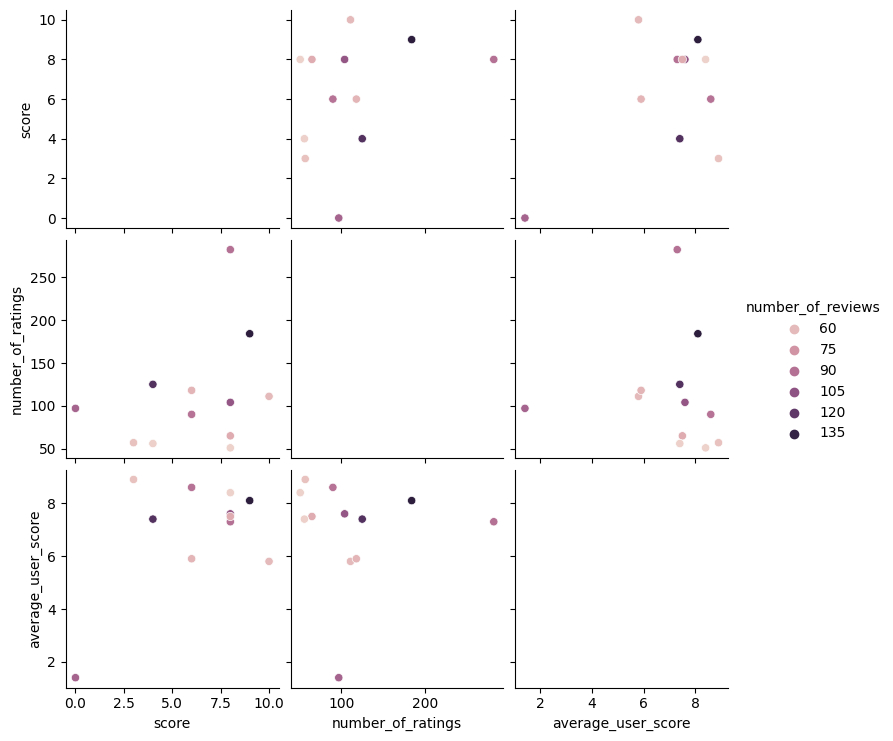

In [52]:
# look at serial reviewers only 
sns.pairplot(arc_df[arc_df["number_of_reviews" ]> 50], hue="number_of_reviews")

In [53]:
# look at review length
def count_toks(r):
    return len(r.split()) 
arc_df["n_toks"] = arc_df["review"].apply(count_toks)
arc_df["n_toks"].describe()

count    827.000000
mean     113.338573
std      159.462320
min        9.000000
25%       27.500000
50%       57.000000
75%      112.000000
max      916.000000
Name: n_toks, dtype: float64

In [54]:
# crop out the obscenely long reviews
perc75 = arc_df["n_toks"].describe()["75%"]
arc_df = arc_df[arc_df["n_toks"] < perc75]
arc_df.shape

(618, 6)

In [55]:
arc_df.sample(n=10)

,review,score,number_of_reviews,number_of_ratings,average_user_score,n_toks
899,This game looks like a beta. It is not finishe...,3,1,1,0.0,75
5,Incredible game that moves the Pokemon series ...,10,5,6,8.0,44
356,this is a salute to all seasoned pokemon playe...,10,1,1,0.0,107
391,"Best pokemon experience I've ever had so far, ...",9,1,1,0.0,28
66,Game is extremely fun. Been playing Pokemon si...,10,3,3,0.0,80
243,"Of course that's not my true rating, but until...",10,1,1,0.0,41
472,"Great game, very addictive and fun. Not 10 bec...",9,1,1,0.0,15
971,"This game is repetitive, empty, and as innovat...",0,4,11,1.1,108
320,"I don't want to write a big review, but this i...",10,1,1,0.0,81
454,Everybody knows that this game looks like ****...,9,5,5,8.8,23


In [56]:
# apply simple conversion: if we know the user often scores pretty high, scale their score back slightly
arc_df["sentiment_score"] = (arc_df["score"] * 0.1)**(1/(arc_df["average_user_score"]*0.1))
arc_df[arc_df["score"] != 10]

C:\Users\Jake\AppData\Local\Temp\ipykernel_18072\1416092664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arc_df["sentiment_score"] = (arc_df["score"] * 0.1)**(1/(arc_df["average_user_score"]*0.1))


,review,score,number_of_reviews,number_of_ratings,average_user_score,n_toks,sentiment_score
362,"A break from standard tradition, Pokemon final...",9,13,31,7.6,36,0.870548
364,Starts off a little slow and the menus are a m...,9,4,4,8.3,25,0.880786
366,Here we have a very good game with the twist o...,9,3,4,9.5,38,0.895023
367,The best Pokémon game in (at least) 10 years. ...,9,1,1,0.0,23,0.000000
368,This game is a solid 9. Probably the best poke...,9,5,6,9.8,44,0.898067
...,...,...,...,...,...,...,...
1058,"This game have bad graphics, bad design, borin...",0,6,6,1.7,64,0.000000
1059,Quite the different Pokemon game from the main...,0,1,1,0.0,32,0.000000
1062,"Final boss is too cheap, that is not fail at a...",0,1,1,0.0,17,0.000000
1063,Boss fights aren’t thought out properly. Too m...,0,1,1,0.0,12,0.000000


In [57]:
arc_df["sentiment_score"].describe()

count    618.000000
mean       0.499279
std        0.473528
min        0.000000
25%        0.000000
50%        0.621172
75%        1.000000
max        1.000000
Name: sentiment_score, dtype: float64

<AxesSubplot:ylabel='Density'>

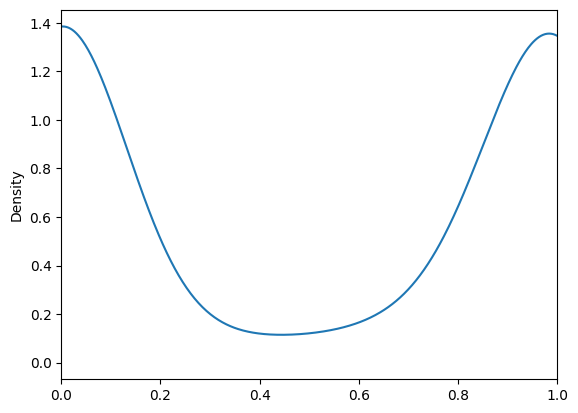

In [58]:
arc_df["sentiment_score"].plot(kind="density", xlim=(0,1))

In [59]:
print(arc_df.shape)
print(arc_df["n_toks"].sum())

(618, 7)
29416


In [60]:
outpath = "proccessed_arceus_reviews.json"
arc_df[["review", "sentiment_score"]].to_json(outpath, orient="records")

We now have 618 reviews, consisting of ~30,000 words with a range of sentiment scores. New reviewers scores are taken at face value whereas serial reviewers scores are scaled with respect to how they usually score games.

## Animal Crossing Reviews

In [61]:
cross_df = pd.read_csv(files[1])
cross_df.head()

,grade,user_name,text,date
0,4,mds27272,My gf started playing before me. No option to ...,2020-03-20
1,5,lolo2178,"While the game itself is great, really relaxin...",2020-03-20
2,0,Roachant,My wife and I were looking forward to playing ...,2020-03-20
3,0,Houndf,We need equal values and opportunities for all...,2020-03-20
4,0,ProfessorFox,BEWARE! If you have multiple people in your h...,2020-03-20


In [62]:
cross_df = cross_df[["grade", "text"]]
cross_df["sentiment_score"] = cross_df["grade"] * 0.1
cross_df

,grade,text,sentiment_score
0,4,My gf started playing before me. No option to ...,0.4
1,5,"While the game itself is great, really relaxin...",0.5
2,0,My wife and I were looking forward to playing ...,0.0
3,0,We need equal values and opportunities for all...,0.0
4,0,BEWARE! If you have multiple people in your h...,0.0
...,...,...,...
2994,1,1 Island for console limitation.I cannot play ...,0.1
2995,1,"Per giocare con figli o fidanzate, mogli o per...",0.1
2996,0,One island per console is a pathetic limitatio...,0.0
2997,2,Even though it seems like a great game with ma...,0.2


In [63]:
cross_df.dropna(inplace=True)

In [64]:
cross_df.describe()

,grade,sentiment_score
count,2999.000000,2999.000000
mean,4.217406,0.421741
std,4.349486,0.434949
min,0.000000,0.000000
25%,0.000000,0.000000
50%,2.000000,0.200000
75%,10.000000,1.000000
max,10.000000,1.000000


In [65]:
# filter to eng
cross_df = cross_df[cross_df["text"].apply(is_en) == "en"]
cross_df.shape

(2827, 3)

In [66]:
cross_df["n_toks"] = cross_df["text"].apply(count_toks)
cross_df["n_toks"].describe()

C:\Users\Jake\AppData\Local\Temp\ipykernel_18072\2873999017.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_df["n_toks"] = cross_df["text"].apply(count_toks)


count    2827.000000
mean      124.887867
std       131.062012
min         3.000000
25%        32.000000
50%        61.000000
75%       185.000000
max       995.000000
Name: n_toks, dtype: float64

In [67]:
# crop out the obscenely long reviews
perc75 = cross_df["n_toks"].describe()["75%"]
cross_df = cross_df[cross_df["n_toks"] < perc75]
cross_df.shape

(2116, 4)

In [68]:
# we don't have anything other than the star score here so let's look at the numbers
cross_df["sentiment_score"].describe()

count    2116.000000
mean        0.414367
std         0.444915
min         0.000000
25%         0.000000
50%         0.100000
75%         1.000000
max         1.000000
Name: sentiment_score, dtype: float64

<AxesSubplot:ylabel='Density'>

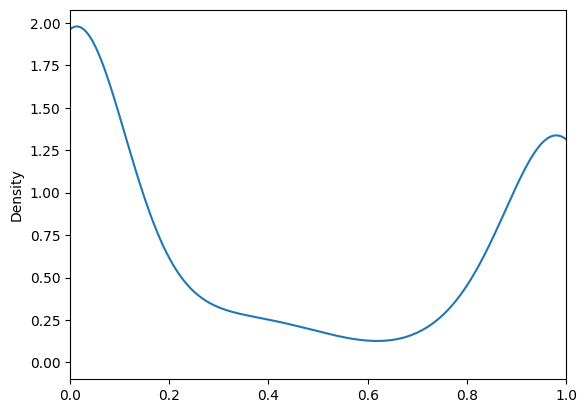

In [69]:
cross_df["sentiment_score"].plot(kind="density", xlim=(0,1))

Not too dissimilar from the arceus reviews, but a little more skewed towards negative.

In [70]:
print(cross_df.shape)
print(cross_df["n_toks"].sum())

(2116, 4)
140458


In [71]:
#rename the text column to review to be in line with the other dataset
cross_df.rename({"text":"review"}, inplace=True, axis=1)
cross_df.head()

,grade,review,sentiment_score,n_toks
0,4,My gf started playing before me. No option to ...,0.4,70
1,5,"While the game itself is great, really relaxin...",0.5,167
3,0,We need equal values and opportunities for all...,0.0,56
4,0,BEWARE! If you have multiple people in your h...,0.0,183
5,0,The limitation of one island per Switch (not p...,0.0,178


In [72]:
outpath = "proccessed_animal_crossing_reviews.json"
cross_df[["review", "sentiment_score"]].to_json(outpath, orient="records")

## Very Brief EDA of Composed Dataset

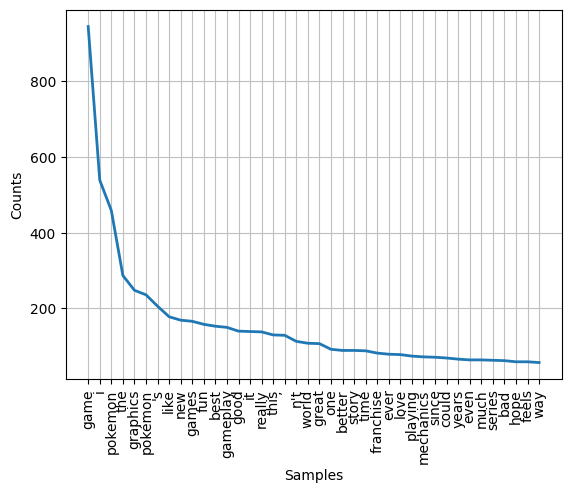

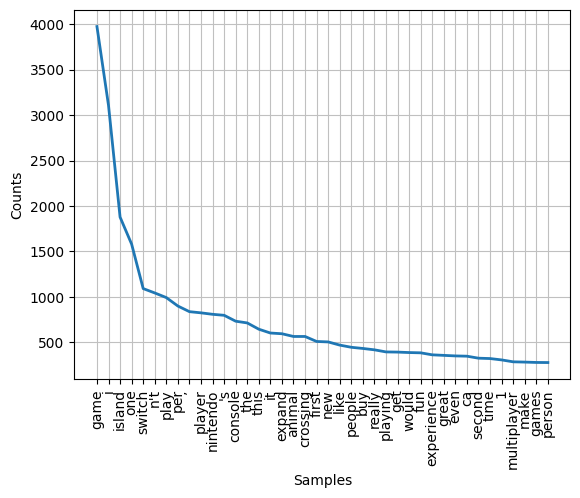

In [73]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords
from string import punctuation


#nltk.download("stopwords")
stopwords = stopwords.words("english") + list(punctuation)

def flatten(l):
    return [item for sublist in l for item in sublist]

def filter(tokens):
    return [tok.lower() for tok in tokens if tok not in stopwords]

for df in [arc_df, cross_df]:
    tokens = df["review"].apply(word_tokenize).to_list()
    tokens = filter(flatten(tokens))
    dist = FreqDist(tokens)
    common = FreqDist(dict(dist.most_common(n=40)))
    common.plot()

Zipfian distributions as expected, but heavy bias towards certain features of the games rather than general words associated with sentiment. This corpus wouldn't make a very good general model. I'll add more genres to diversify the samples.

Also, ~3000 samples isn't really enough to model language anyway.

## Additional Data 

In [74]:
# the full dataset is enormous so isn't in this repo. I make a subset here
original_path = "E:\\amazon_book_reviews\\Books_rating.csv"
books_df = pd.read_csv(original_path)
books_df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [75]:
def helpful_to_int(a):
    vals = [int(v) for v in a.strip().split("/")]
    if vals[1] != 0:
        return vals[0]/vals[1]
    return 0

books_df["review/helpfulness"] = books_df["review/helpfulness"].apply(helpful_to_int)
books_df = books_df[["Title", "review/helpfulness", "review/score", "review/summary", "review/text"]]
books_df.head()

,Title,review/helpfulness,review/score,review/summary,review/text
0,Its Only Art If Its Well Hung!,1.000000,4.0,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,Dr. Seuss: American Icon,1.000000,5.0,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,Dr. Seuss: American Icon,0.909091,5.0,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,Dr. Seuss: American Icon,1.000000,4.0,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,Dr. Seuss: American Icon,1.000000,4.0,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [76]:
books_df = books_df[books_df["review/helpfulness"] == 1]
books_df.shape

(831783, 5)

In [77]:
subset = books_df.sample(n=3000)
subset["Title"].describe()

count                    3000
unique                   2630
top       Pride and Prejudice
freq                       25
Name: Title, dtype: object

In [78]:
# make two types of reviews. Just the summary and the full review

book_sum_df = subset.sample(n=1000)
book_full_df = subset.drop(book_sum_df.index)

book_sum_df.drop("review/text",axis=1,inplace=True)
book_sum_df.rename({"review/summary":"review"}, axis=1, inplace=True)

book_full_df.drop("review/summary",axis=1, inplace=True)
book_full_df.rename({"review/text":"review"}, axis=1, inplace=True)

In [79]:
# we've already filtered to only helpful reviews so let's drop that col
book_sum_df.drop("review/helpfulness",axis=1,inplace=True)
book_full_df.drop("review/helpfulness",axis=1,inplace=True)

In [80]:
book_full_df

,Title,review/score,review
277879,Old Yeller (A Literature unit),5.0,This is one of the best books I have ever read...
899407,Eaters Of The Dead,4.0,Contrary to what has been said by many of the ...
2086023,"God's Playground: A History of Poland, Vol. 1:...",5.0,"As a child of a Pole, I have been appalled by ..."
2521067,Here's How to Reach Me: Matching Instruction t...,5.0,I bought this book because I wanted to learn a...
1418234,Flowers in the Attic,4.0,"I remember watching the movie version of ""Flow..."
...,...,...,...
275589,Bury My Heart at Wounded Knee: An Indian Histo...,5.0,This illustrated edition is a very beautiful b...
872855,The Art of the Novel,5.0,Milan Kundera is a Czechoslavakian writer who ...
1965406,Jurassic Park,5.0,I read this book when I was in high school whi...
2181893,Little Lord Fauntleroy,5.0,This is another book that I can hardly wait to...


In [81]:
book_sum_df

,Title,review/score,review
739331,One Flew Over the Cuckoo's Nest,5.0,This entertaining and often hilarious read rem...
2989652,In Silent Graves,5.0,Wonderful!
1271699,Flight of the Swan,5.0,Historical fiction at its best
2350448,The Art of Noir: THE POSTERS & GRAPHICS FROM T...,5.0,Stunning Showcase of the Poster Art of Classic...
118513,Eurocomunismo y estado (Temas hispanicos) (Spa...,4.0,Un t&iacute;tulo imprescindible para comprende...
...,...,...,...
2945959,A Death In The Family,5.0,"Sad, beautiful, artistic and real - this book ..."
2348337,Goodnight Train,5.0,Another fantastic train bedtime book!
657121,Murach's VB.NET Database Programming with ADO.NET,5.0,Another masterpiece from Murach's series
1682671,The Hobbit,5.0,Definitely There and Back Again


In [82]:
book_full_df.describe()

,review/score
count,2000.000000
mean,4.515000
std,0.877588
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [83]:
book_sum_df.describe()

,review/score
count,1000.000000
mean,4.531000
std,0.864747
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [84]:
#recombine them
books_sub_df = pd.concat([book_sum_df, book_full_df])
books_sub_df

,Title,review/score,review
739331,One Flew Over the Cuckoo's Nest,5.0,This entertaining and often hilarious read rem...
2989652,In Silent Graves,5.0,Wonderful!
1271699,Flight of the Swan,5.0,Historical fiction at its best
2350448,The Art of Noir: THE POSTERS & GRAPHICS FROM T...,5.0,Stunning Showcase of the Poster Art of Classic...
118513,Eurocomunismo y estado (Temas hispanicos) (Spa...,4.0,Un t&iacute;tulo imprescindible para comprende...
...,...,...,...
275589,Bury My Heart at Wounded Knee: An Indian Histo...,5.0,This illustrated edition is a very beautiful b...
872855,The Art of the Novel,5.0,Milan Kundera is a Czechoslavakian writer who ...
1965406,Jurassic Park,5.0,I read this book when I was in high school whi...
2181893,Little Lord Fauntleroy,5.0,This is another book that I can hardly wait to...


In [86]:
# drop non english
books_sub_df = books_sub_df[books_sub_df["review"].apply(is_en) == "en"]
books_sub_df.shape

(2881, 3)

In [87]:
books_sub_df["n_toks"] = books_sub_df["review"].apply(count_toks)
books_sub_df.head()

C:\Users\Jake\AppData\Local\Temp\ipykernel_18072\2501823406.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_sub_df["n_toks"] = books_sub_df["review"].apply(count_toks)


,Title,review/score,review,n_toks
739331,One Flew Over the Cuckoo's Nest,5.0,This entertaining and often hilarious read rem...,7
1271699,Flight of the Swan,5.0,Historical fiction at its best,5
2350448,The Art of Noir: THE POSTERS & GRAPHICS FROM T...,5.0,Stunning Showcase of the Poster Art of Classic...,10
344537,What Buddha Never Taught,5.0,"Fascinating, stimulating and fun tale..",5
2794916,A Bride Most Begrudging,5.0,This was amazing!!!,3


In [88]:
books_sub_df["sentiment_score"] = books_sub_df["review/score"]*0.2
books_sub_df.drop("review/score", axis=1, inplace=True)
books_sub_df

C:\Users\Jake\AppData\Local\Temp\ipykernel_18072\4225197127.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_sub_df["sentiment_score"] = books_sub_df["review/score"]*0.2
C:\Users\Jake\AppData\Local\Temp\ipykernel_18072\4225197127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_sub_df.drop("review/score", axis=1, inplace=True)


,Title,review,n_toks,sentiment_score
739331,One Flew Over the Cuckoo's Nest,This entertaining and often hilarious read rem...,7,1.0
1271699,Flight of the Swan,Historical fiction at its best,5,1.0
2350448,The Art of Noir: THE POSTERS & GRAPHICS FROM T...,Stunning Showcase of the Poster Art of Classic...,10,1.0
344537,What Buddha Never Taught,"Fascinating, stimulating and fun tale..",5,1.0
2794916,A Bride Most Begrudging,This was amazing!!!,3,1.0
...,...,...,...,...
275589,Bury My Heart at Wounded Knee: An Indian Histo...,This illustrated edition is a very beautiful b...,242,1.0
872855,The Art of the Novel,Milan Kundera is a Czechoslavakian writer who ...,283,1.0
1965406,Jurassic Park,I read this book when I was in high school whi...,85,1.0
2181893,Little Lord Fauntleroy,This is another book that I can hardly wait to...,27,1.0


In [89]:
books_sub_df.drop("Title", axis=1, inplace=True)
books_sub_df

C:\Users\Jake\AppData\Local\Temp\ipykernel_18072\2703216620.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_sub_df.drop("Title", axis=1, inplace=True)


,review,n_toks,sentiment_score
739331,This entertaining and often hilarious read rem...,7,1.0
1271699,Historical fiction at its best,5,1.0
2350448,Stunning Showcase of the Poster Art of Classic...,10,1.0
344537,"Fascinating, stimulating and fun tale..",5,1.0
2794916,This was amazing!!!,3,1.0
...,...,...,...
275589,This illustrated edition is a very beautiful b...,242,1.0
872855,Milan Kundera is a Czechoslavakian writer who ...,283,1.0
1965406,I read this book when I was in high school whi...,85,1.0
2181893,This is another book that I can hardly wait to...,27,1.0


<AxesSubplot:ylabel='Density'>

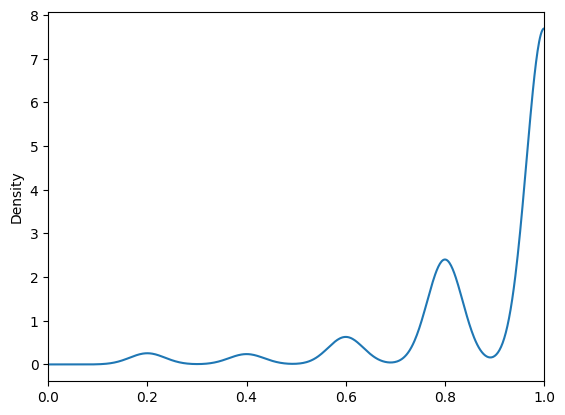

In [90]:
books_sub_df["sentiment_score"].plot(kind="density", xlim=(0,1))

In [91]:
outpath = "proccessed_book_reviews.json"
books_sub_df[["review", "sentiment_score"]].to_json(outpath, orient="records")

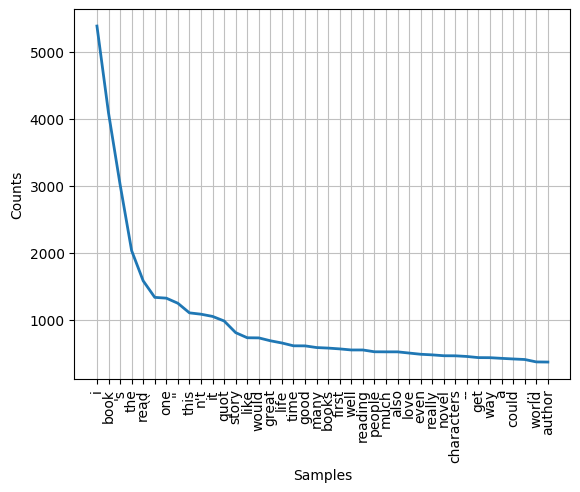

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [92]:
tokens = books_sub_df["review"].apply(word_tokenize).to_list()
tokens = filter(flatten(tokens))
dist = FreqDist(tokens)
common = FreqDist(dict(dist.most_common(n=40)))
common.plot()

In [ ]:
pd.concat([books_sub_df, arc_df, cross_df])